In [1]:
import random

from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate, VerticalFlip, Crop, PixelDropout, CropAndPad, RandomBrightnessContrast
)
import config
import paths
import randomness
from cnn_builder import *
from config import *
from dataset_functions import *
from functools import partial
from hypercube_set import HypercubeSet
from hypercube_loader import *
import numpy as np
import random
import rendering
import training_history

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
os.chdir(os.getcwd().split("jupyter")[0])

inf = 2e32

%load_ext autoreload
%autoreload 2
%pylab inline

read_json_config(paths.config_file, network_type=None)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning:

pylab import has clobbered these variables: ['shuffle', 'copy', 'inf', 'random']
`%matplotlib` prevents importing * from pylab and numpy



In [2]:
hc_array_red, max_class_idx = load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf, folder='media/Mateus_2022/red/')

Reading media/Mateus_2022/red\raw_112_rf.hdr ...
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
Reading media/Mateus_2022/red\raw_1984_rf.hdr ...
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
Reading media/Mateus_2022/red\raw_3904_rf.hdr ...
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
Reading media/Mateus_2022/red\raw_5744_rf.hdr ...
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
Reading media/Mateus_2022/red\raw_7584_rf.hdr ...
[0. 1. 2. 3. 4.]


In [20]:
hc_array_white, max_class_idx = load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf, folder='media/Mateus_2022/white/', baseline_class_idx=max_class_idx)

Reading media/Mateus_2022/white\raw_11888_rf.hdr ...
[ 0.  9. 10. 11.]
Reading media/Mateus_2022/white\raw_13040_rf.hdr ...
[ 0.  9. 10. 11.]
Reading media/Mateus_2022/white\raw_15040_rf.hdr ...
[ 0.  9. 10.]
Reading media/Mateus_2022/white\raw_16064_rf.hdr ...
[ 0.  9. 10. 11. 12. 13. 14.]
Reading media/Mateus_2022/white\raw_18064_rf.hdr ...
[ 0.  9. 10. 11. 12. 13.]
Reading media/Mateus_2022/white\raw_19008_rf.hdr ...
[ 0.  9. 10. 11. 12. 13.]
Reading media/Mateus_2022/white\raw_9888_rf.hdr ...
[ 0.  9. 10. 11.]


In [6]:
hc_array = hc_array_red + hc_array_white
hc_set = HypercubeSet(hc_array)

In [7]:
hc_set.identify_ground_samples()

In [9]:
network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)
network_name = get_name(network_type)

read_json_config(paths.config_file, network_type=network_type)

hc_set.split_hypercubes(test_percentage=test_split, patch_size=config.patch_size, patch_overlapping=config.patch_overlapping)

In [10]:
hc_set.standardize()

|████████████████████████████████████████| 20/20 [100%] in 48.9s (0.40/s)                                               


(FactorAnalysis(n_components=30, random_state=42), StandardScaler())

In [11]:
print(config.test_split)

Splitting hypercube:  <hypercube.Hypercube object at 0x000001D0857EBD90>
patches shape:  (28611, 23, 23, 30)
labels shape:  (28611,)
Splitting hypercube:  <hypercube.Hypercube object at 0x000001D085829670>
patches shape:  (29684, 23, 23, 30)
labels shape:  (29684,)
Splitting hypercube:  <hypercube.Hypercube object at 0x000001D085829970>
patches shape:  (23240, 23, 23, 30)
labels shape:  (23240,)
Splitting hypercube:  <hypercube.Hypercube object at 0x000001D085829490>
patches shape:  (21374, 23, 23, 30)
labels shape:  (21374,)
Splitting hypercube:  <hypercube.Hypercube object at 0x000001D085829160>
patches shape:  (1978, 23, 23, 30)
labels shape:  (1978,)


In [12]:
X_train, y_train = hc_set.split(patch_size=config.patch_size, patch_overlap=config.patch_overlapping, train=True)

Splitting hypercube:  <hypercube.Hypercube object at 0x000001D0857EBD90>
patches shape:  (28543, 23, 23, 30)
labels shape:  (28543,)
Splitting hypercube:  <hypercube.Hypercube object at 0x000001D085829670>
patches shape:  (29736, 23, 23, 30)
labels shape:  (29736,)
Splitting hypercube:  <hypercube.Hypercube object at 0x000001D085829970>
patches shape:  (23316, 23, 23, 30)
labels shape:  (23316,)
Splitting hypercube:  <hypercube.Hypercube object at 0x000001D085829490>
patches shape:  (21402, 23, 23, 30)
labels shape:  (21402,)
Splitting hypercube:  <hypercube.Hypercube object at 0x000001D085829160>
patches shape:  (1908, 23, 23, 30)
labels shape:  (1908,)


In [75]:
X_test, y_test = hc_set.split(patch_size=config.patch_size, patch_overlap=config.patch_overlapping, train=False)

Splitting hypercube:  <hypercube.Hypercube object at 0x0000022C9183FA60>
patches shape:  (42864, 23, 23, 30)
labels shape:  (42864,)
Splitting hypercube:  <hypercube.Hypercube object at 0x0000022C811396D0>
patches shape:  (44550, 23, 23, 30)
labels shape:  (44550,)
Splitting hypercube:  <hypercube.Hypercube object at 0x0000022C81139430>
patches shape:  (34891, 23, 23, 30)
labels shape:  (34891,)
Splitting hypercube:  <hypercube.Hypercube object at 0x0000022C81139790>
patches shape:  (32078, 23, 23, 30)
labels shape:  (32078,)
Splitting hypercube:  <hypercube.Hypercube object at 0x0000022C81139370>
patches shape:  (2893, 23, 23, 30)
labels shape:  (2893,)


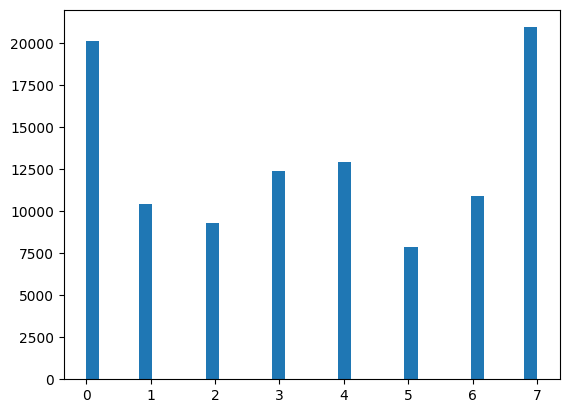

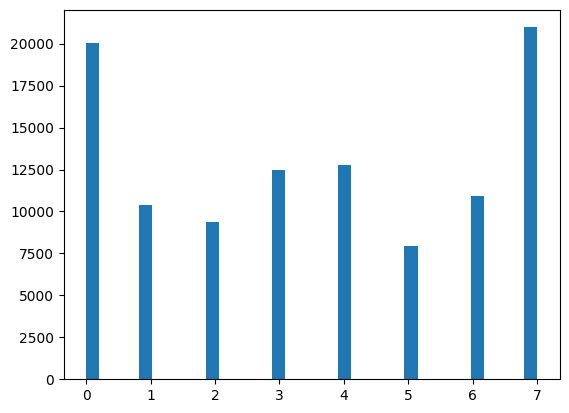

In [13]:
render_mask_histogram(y_train)
render_mask_histogram(y_test)

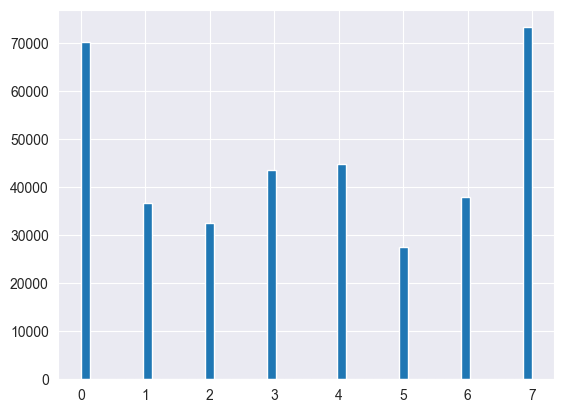

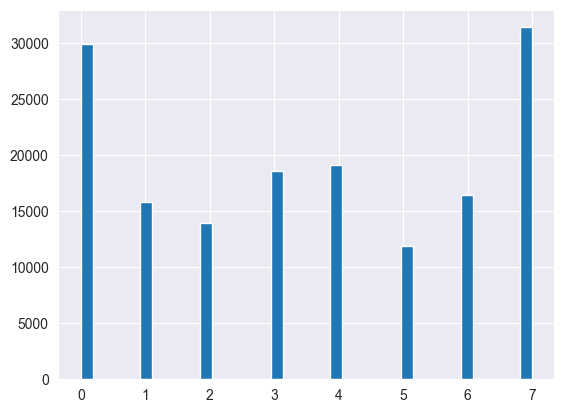

In [76]:
reflectance_std = np.std(X_train)
mean_spectral_std = np.mean(reflectance_std)
print(mean_spectral_std)

In [63]:
transforms = Compose([
            HorizontalFlip(p=0.25),
            VerticalFlip(p=0.25),
            Rotate(limit=45, p=0.25),
        ])

0.9268594537081192


In [64]:
X_train_augmented = X_train.copy()
augment_fn2 = X_train.copy()

for i in range(len(X_train)):
    random_seed = np.random.randint(0, X_train.shape[0] * 10)
    randomness.set_seed(random_seed)
    X_train_augmented[i, :, :, 0] = transforms(image=X_train[i, :, :, 0])["image"]
    randomness.set_seed(random_seed)
    augment_fn2[i, :, :, 0] = transforms(image=X_train[i, :, :, 1])["image"]

# Compute distance between augmented images
print(np.linalg.norm(X_train_augmented - augment_fn2))

fig = plt.figure(figsize=(7, 15))
for i in range(28):
    ax = fig.add_subplot(7, 4, i+1, xticks=[], yticks=[])
    if i % 4 == 0:
        ax.imshow(X_train_augmented[i // 4, :, :, 0])
    elif i % 4 == 1:
        ax.imshow(augment_fn2[i // 4, :, :, 0])
    elif i % 4 == 2:
        ax.imshow(X_train[i // 4, :, :, 0])
    else:
        ax.imshow(X_train[i // 4, :, :, 1])

In [14]:
print(np.unique(y_train))

[0. 1. 2. 3. 4. 5. 6. 7.]


In [45]:
from keras.utils import Sequence

class TransformedBatch(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations, validation_sequence, num_epochs, num_splits=5):
        self.x, self.y = x_set, y_set
        self.len_x = self.x.shape[0]
        self.batch_size = batch_size
        self.augment = augmentations
        self.validation_sequence = validation_sequence
        self.k_fold_indices = None
        self.num_splits = num_splits
        self.epoch = 0
        self.k_fold_idx = 0
        self.num_epochs = num_epochs

        self.build_kfold()
        self.train_indices, validation = self.get_kfold(self.k_fold_idx)
        self.validation_sequence.set_validation_set(self.x[validation], self.y[validation])

    def __len__(self):
        return int(np.ceil(len(self.train_indices) / float(self.batch_size)))

    def __getitem__(self, idx):
        train_x, train_y = self.x[self.train_indices], self.y[self.train_indices]
        batch_x = train_x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = train_y[idx * self.batch_size:(idx + 1) * self.batch_size]

        for i in range(len(batch_x)):
            for layer in range(batch_x.shape[-1]):
                randomness.set_seed(42)
                batch_x[i, :, :, layer] = self.augment(image=batch_x[i, :, :, layer])["image"]

        return batch_x, batch_y

    def __on_epoch_end__(self):
        self.epoch += 1
        new_k_fold_idx = self.epoch // (self.num_epochs // self.num_splits)

        if new_k_fold_idx != self.k_fold_idx:
            self.k_fold_idx = new_k_fold_idx
            train, validation = self.get_kfold(self.k_fold_idx)
            self.validation_sequence.set_validation_set(self.x[validation], self.y[validation])

    def build_kfold(self):
        # Get self.len_x random indices
        self.k_fold_indices = np.random.permutation(self.len_x)

    def get_kfold(self, idx):
        print(idx)
        k_fold_validation = self.k_fold_indices[idx * self.len_x // self.num_splits:(idx + 1) * self.len_x // self.num_splits]
        k_fold_train = np.delete(self.k_fold_indices, k_fold_validation)

        return k_fold_train, k_fold_validation

class TransformedValidation(Sequence):
    def __init__(self):
        self.x, self.y = None, None

    def __len__(self):
        return int(len(self.x))

    def __getitem__(self, idx):
        return self.x, self.y

    def set_validation_set(self, x, y):
        self.x, self.y = x, y

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


In [46]:
validation_sequence = TransformedValidation()
transformed_x_train = TransformedBatch(X_train, y_train, batch_size=128, augmentations=transforms, validation_sequence=validation_sequence, num_epochs=50, num_splits=5)

for i in range(50):
    train_idx, test_idx = transformed_x_train.get_kfold(i // (50 // 5))
    transformed_x_train.__on_epoch_end__()
    # print(test_idx)

In [32]:
from cnn_builder import force_gpu

force_gpu()

Number of GPUs: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [47]:
X_train_transformed = X_train.copy()

for i in range(len(X_train_transformed)):
    random_seed = np.random.randint(0, X_train_transformed.shape[0] * 10)
    for layer in range(X_train_transformed.shape[-1]):
        randomness.set_seed(random_seed)
        X_train_transformed[i, :, :, layer] = transforms(image=X_train_transformed[i, :, :, layer])["image"]

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:21:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:49:00.0, compute capability: 8.6

Number of GPUs: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [16]:
network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)

network_name = get_name(network_type)
num_classes = hc_set.get_num_classes()
img_shape = X_train[0].shape

validation_sequence = TransformedValidation()
transformed_x_train = TransformedBatch(X_train, y_train, batch_size=16, augmentations=transforms, validation_sequence=validation_sequence, num_epochs=config.epochs, num_splits=3)

history = training_history.TrainingHistory(accuracy_name='sparse_categorical_accuracy')
callbacks, time_callback = get_callback_list(model_name=network_name)
model = build_network(network_type=network_type, num_classes=num_classes, image_dim=img_shape)
compile_network(model, network_type, network_name, num_classes, show_summary=True, render_image=True)

for it in range(5):
    X_train_transformed = X_train.copy()

    for i in range(len(X_train_transformed)):
        random_seed = np.random.randint(0, X_train_transformed.shape[0] * 10)
        for layer in range(X_train_transformed.shape[-1]):
            randomness.set_seed(random_seed)
            X_train_transformed[i, :, :, layer] = transforms(image=X_train_transformed[i, :, :, layer])["image"]

    history.append_history(run_model(model, X_train_transformed, y_train, validation_split=validation_split, callbacks=callbacks).history, time_callback)

{'optimizer': <keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x000001D0F936A820>, 'callbacks': [], 'intermediate_activation': 'relu', 'kernel_size': 3, 'start_size': 16, 'strides': 2}
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 23, 23, 30)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 23, 23, 16)   496         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 12, 12, 16)   2320        ['conv2d[0][0]']                 

KeyboardInterrupt: 

In [4]:
prediction = model.predict(X_test)
model_predictions = np.argmax(prediction, axis=1)
render_confusion_matrix(y_test, model_predictions, network_name)

NameError: name 'hc_set' is not defined